In [10]:
from typing import Annotated, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

from langchain.tools import tool
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

from pydantic import BaseModel, Field

from IPython.display import Image, display
import gradio as gr
import requests
import os
import uuid

from dotenv import load_dotenv
load_dotenv(override=True)

True

# evaluattor output

In [11]:
# we use evaluator node, which should output this
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="whether the success criteria have been met")
    user_input_needed: bool= Field(description="whether more input or clarification is needed from user, or the assistant is stuck")


# main graph state
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str] #why duplicated with evaluatorOuput?
    success_criteria_met: bool
    user_input_needed: bool

    

# declare browser

In [12]:
import nest_asyncio
nest_asyncio.apply()
async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

# declare LLM for nodes in langgraph

In [13]:
llm_openai = ChatOpenAI(model="gpt-4o-mini")
llm_deepseek = ChatOpenAI(
    model="deepseek-chat",                # DeepSeek chat model name
    base_url="https://api.deepseek.com/v1",
    api_key=os.environ["DEEPSEEK_API_KEY"],
    temperature=0.5,
)

llm = llm_deepseek

worker_llm = llm
worker_llm_with_tools = worker_llm.bind_tools(tools)

evaluator_llm = llm
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput) #hijacking toolcalling or function calling method to regulate output format: https://forum.langchain.com/t/clarification-on-how-pydantic-schema-descriptions-are-used-in-with-structured-output/1612?utm_source=chatgpt.com 



# declare worker node in langgraph

In [14]:
def worker(state: State) -> Dict[str, Any]:
    """processing logic of the worker node"""
    system_message = f"""You are a helpful assistant that use tools to complete tasks.
Keep working on task until you have questions or clarification from users or success criteria are met.
Success criteria:
{state["success_criteria"]}
Reply either with a question or with your final response.
If question, clearly state the question. Example: please clarify for <the unclear thing> is either <option 1> or <option 2> or <option 3> etc...
If finished, final response should not be a question.
"""

    if state.get("feedback_on_work"):
        system_message = f"""
Your previous reply is incomplete and rejected. Here is the feedback: 
{state['feedback_on_work']}
Use this feedback to continue the assignment, verify if success criteria is met or question to users is required.
"""
    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            found_system_message = True
    # we only append system message once, should be at the first time this worker is invoked
    if not found_system_message: 
        messages = [SystemMessage(content=system_message)] + messages
    #why processing task receive raw HumanMesage and AIMessage class
    response = worker_llm_with_tools.invoke(messages) # -> No worries, langchain automatically extract {"role": ..., "content": ...} as input to LLM. https://docs.langchain.com/oss/python/langchain/models
    #response here should have tool_calls key if they decide to invoke

    return {"messages": [response]}


def worker_router(state:State):
    """custom made tool routing function for conditional edge in langgraph"""
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and last_message.tool_calls: #note: last_message maybe HumanMessage or AIMessage, not a dict
        return "tools"
    else:
        return "evaluator"



In [15]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history: \n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation  #but here we only get content

def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """You are strict and succint evaluator who determines if a task is completed successfully by an Assistant or not.
Assess the Assistant's last response, and provide feedback and decision whether the success criteria has been met.
"""
    user_message = f"""You are evaluating a conversation between the User and Assistant.
Conversation history with assistant, starting with user original request is:
{format_conversation(state["messages"])}

Success criteria for this assignment:
{state["success_criteria"]}

Final response from the Assistant for evaluation:
{last_response}

Now, begin evaluating.
"""
    if state["feedback_on_work"]: 
        user_message += f"Also, in previous attempt from the Assistant, you provided feedback: {state['feedback_on_work']}\n"
        user_message += f"If assistant repeat the mistakes, consider responding that user input is required.\n"

    evaluator_message = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_message)
    new_state = { 
        #message include information that also attached to the state
        "messages": [{"role": "assistant", "content": f"Evaluator's feedback on this answer: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state

def evaluator_router(state: State):
    """Evaluator router, used on conditional edge on langgraph, Nope, maybe it as there is no tool call, but may be still condition to worker node"""
    if state['success_criteria_met'] or state['user_input_needed']:
        return "END" # ok criteria, ready to answer, or need to double check
    else:
        return "worker"
    

### Now define the graph

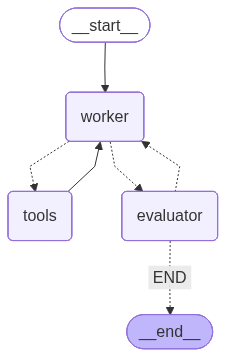

In [16]:
graph_builder = StateGraph(State)
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

graph_builder.add_edge(START, "worker")
graph_builder.add_conditional_edges("worker", worker_router, {'tools': 'tools', 'evaluator': 'evaluator'})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", evaluator_router, {"END": END, 'worker': 'worker'})

memory_ram = MemorySaver()
graph = graph_builder.compile(checkpointer=memory_ram)

display(Image(graph.get_graph().draw_mermaid_png()))


### Gradio call back and super step??

In [19]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

async def process_message(message, success_criteria, history, thread):
    config = {"configurable": {"thread_id": thread}}

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await graph.ainvoke(state, config=config)

    user = {"role": "user", "content": message} # a user message input to LLM
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}

    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()


    

    

In [20]:


with gr.Blocks() as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    with gr.Row():
        chatbot = gr.Chatbot(
            label="Sidekick",
            height=300,
        )

    with gr.Group():
        with gr.Row():
            message = gr.Textbox(
                show_label=False,
                placeholder="Your request to your sidekick",
            )

        with gr.Row():
            success_criteria = gr.Textbox(
                show_label=False,
                placeholder="What are your success criteria?",
            )

    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")

    message.submit(
        process_message,
        [message, success_criteria, chatbot, thread],
        [chatbot],
    )

    success_criteria.submit(
        process_message,
        [message, success_criteria, chatbot, thread],
        [chatbot],
    )

    go_button.click(
        process_message,
        [message, success_criteria, chatbot, thread],
        [chatbot],
    )

    reset_button.click(
        reset,
        [],
        [message, success_criteria, chatbot, thread]
    )

demo.launch()
        

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/home/anh/workspace/course-udemy-agentic-enginer/.venv./lib/python3.12/site-packages/gradio/queueing.py", line 763, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anh/workspace/course-udemy-agentic-enginer/.venv./lib/python3.12/site-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anh/workspace/course-udemy-agentic-enginer/.venv./lib/python3.12/site-packages/gradio/blocks.py", line 2106, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anh/workspace/course-udemy-agentic-enginer/.venv./lib/python3.12/site-packages/gradio/blocks.py", line 1586, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anh/workspace/cour